In [2]:
import pickle

# Load the RML2016.10a dataset (.pkl file)
with open('RML2016.10a_dict.pkl', 'rb') as f:
    dataset = pickle.load(f, encoding='latin1')  # Use 'latin1' encoding for compatibility with Python 3


In [3]:
import tensorflow as tf

# Check if GPU is available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth to prevent TensorFlow from allocating all GPU memory
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs.")
    except RuntimeError as e:
        print(e)  # RuntimeError will be raised if memory growth is set after the runtime is initialized
else:
    print("No GPU found.")

Memory growth set for GPUs.


In [4]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define the stem block with further reduced filters
def stem_block(input_tensor):
    x = layers.Conv2D(8, (1, 3), strides=2, activation='relu')(input_tensor)  # Further reduced filters
    x = layers.Conv2D(8, (1, 3), activation='relu')(x)
    x = layers.Conv2D(16, (1, 3), activation='relu')(x)  # Further reduced filters
    x = layers.MaxPooling2D((1, 2), strides=2)(x)  # Changed pooling size
    return x

# Define Inception-ResNet block A with further reduced filters
def inception_resnet_block_A(input_tensor, scale=0.17):
    branch_1 = layers.Conv2D(8, (1, 1), activation='relu')(input_tensor)  # Further reduced filters
    
    branch_2 = layers.Conv2D(8, (1, 1), activation='relu')(input_tensor)
    branch_2 = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(branch_2)
    
    branch_3 = layers.Conv2D(8, (1, 1), activation='relu')(input_tensor)
    branch_3 = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(branch_3)
    branch_3 = layers.Conv2D(12, (3, 3), padding='same', activation='relu')(branch_3)
    
    mixed = layers.Concatenate()([branch_1, branch_2, branch_3])
    up = layers.Conv2D(64, (1, 1), activation=None)(mixed)  # Reduced output channels
    
    # Adjust input dimensions with a 1x1 conv layer to match the 'up' tensor dimensions
    input_tensor = layers.Conv2D(64, (1, 1), activation=None)(input_tensor)  # Reduced output channels
    
    # Residual connection
    x = layers.add([input_tensor, up])
    x = layers.ReLU()(x)
    return x

# Define Inception-ResNet block B with reduced filters
def inception_resnet_block_B(input_tensor, scale=0.10):
    branch_1 = layers.Conv2D(32, (1, 1), activation='relu')(input_tensor)  # Further reduced filters
    
    branch_2 = layers.Conv2D(40, (1, 7), padding='same', activation='relu')(input_tensor)
    branch_2 = layers.Conv2D(48, (7, 1), padding='same', activation='relu')(branch_2)
    
    mixed = layers.Concatenate()([branch_1, branch_2])
    up = layers.Conv2D(128, (1, 1), activation=None)(mixed)  # Reduced output channels
    
    # Adjust input dimensions with a 1x1 conv layer to match the 'up' tensor dimensions
    input_tensor = layers.Conv2D(128, (1, 1), activation=None)(input_tensor)  # Reduced output channels
    
    # Residual connection
    x = layers.add([input_tensor, up])
    x = layers.ReLU()(x)
    return x

# Define Inception-ResNet block C with reduced filters
def inception_resnet_block_C(input_tensor, scale=0.20):
    branch_1 = layers.Conv2D(48, (1, 1), activation='relu')(input_tensor)  # Further reduced filters
    
    branch_2 = layers.Conv2D(56, (1, 3), padding='same', activation='relu')(input_tensor)
    branch_2 = layers.Conv2D(64, (3, 1), padding='same', activation='relu')(branch_2)
    
    mixed = layers.Concatenate()([branch_1, branch_2])
    up = layers.Conv2D(256, (1, 1), activation=None)(mixed)  # Reduced output channels
    
    # Adjust input dimensions with a 1x1 conv layer to match the 'up' tensor dimensions
    input_tensor = layers.Conv2D(256, (1, 1), activation=None)(input_tensor)  # Reduced output channels
    
    # Residual connection
    x = layers.add([input_tensor, up])
    x = layers.ReLU()(x)
    return x

# Define reduction block with a check for height
def reduction_block(x):
    if x.shape[1] <= 1:  # Check if height is less than or equal to 1
        x = layers.MaxPooling2D(pool_size=(1, 2))(x)  # Only reduce width
    else:
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Standard 2x2 pooling
    return x

# Build the full model with reduced complexity
def build_inception_resnet_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # Stem
    x = stem_block(input_layer)
    
    # Inception-ResNet A (repeated 2 times)
    for _ in range(2):
        x = inception_resnet_block_A(x)
    
    # Reduction
    x = reduction_block(x)
    
    # Inception-ResNet B (repeated 3 times)
    for _ in range(3):
        x = inception_resnet_block_B(x)
    
    # Reduction
    x = reduction_block(x)
    
    # Inception-ResNet C (repeated 2 times)
    for _ in range(2):
        x = inception_resnet_block_C(x)
    
    # Average pooling, dropout, and softmax output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Adjusted dropout rate
    output_layer = layers.Dense(11, activation='softmax')(x)
    
    model = models.Model(input_layer, output_layer)
    return model

# Set input shape
input_shape = (2, 128, 1)  # Example: IQ data with 2 channels and 128 time steps

# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')  # This sets the global policy

# Build the model
model = build_inception_resnet_model(input_shape)

# Compile the model with AdamW optimizer
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 63, 8)     32          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 61, 8)     200         ['conv2d[0][0]']                 
                                     

In [5]:
import numpy as np

# Normalize IQ samples to the range [-1, 1]
def normalize_iq_samples(iq_samples):
    max_val = np.max(np.abs(iq_samples))  # Find the maximum absolute value
    return iq_samples / max_val  # Normalize to the range [-1, 1]

# Apply normalization to the entire dataset
normalized_dataset = {}
for key in dataset:
    normalized_dataset[key] = normalize_iq_samples(dataset[key])

In [6]:
from sklearn.model_selection import train_test_split

# Create a train/test split from the dataset
def create_train_test_split(dataset, test_size=0.2):
    X, y = [], []

    # Loop over the dataset to collect IQ samples and labels
    for key, data in dataset.items():
        mod_type, snr = key  # Extract modulation type and SNR
        X.append(data)  # Append IQ data
        y.extend([mod_type] * data.shape[0])  # Create corresponding labels for each sample

    # Convert lists to arrays
    X = np.concatenate(X, axis=0)  # Concatenate all IQ data
    y = np.array(y)  # Convert labels to array

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    return X_train, X_test, y_train, y_test

# Split the normalized dataset
X_train, X_test, y_train, y_test = create_train_test_split(normalized_dataset)

In [7]:
!pip install scikit-learn

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert encoded labels to one-hot format
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Check the label encoding mapping (modulation types to integers)
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

{'8PSK': 0, 'AM-DSB': 1, 'AM-SSB': 2, 'BPSK': 3, 'CPFSK': 4, 'GFSK': 5, 'PAM4': 6, 'QAM16': 7, 'QAM64': 8, 'QPSK': 9, 'WBFM': 10}


In [9]:
# Reshape your input data to match the input shape required by the model
X_train_reshaped = X_train.reshape(176000, 2, 128, 1)  # Adjust the shape to (num_samples, height, width, channels)
X_test_reshaped = X_test.reshape(44000, 2, 128, 1)      # Adjust the shape to (num_samples, height, width, channels)

# Check the shape of the reshaped data
print(X_train_reshaped.shape)  # Should show (176000, 2, 128, 1)
print(X_test_reshaped.shape)   # Should show (44000, 2, 128, 1)

(176000, 2, 128, 1)
(44000, 2, 128, 1)


In [10]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, mixed_precision, regularizers, optimizers

# # Define the stem block with further reduced filters
# def stem_block(input_tensor):
#     x = layers.Conv2D(8, (1, 3), strides=2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_tensor)  # Further reduced filters
#     x = layers.Conv2D(8, (1, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
#     x = layers.Conv2D(16, (1, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Further reduced filters
#     x = layers.MaxPooling2D((1, 2), strides=2)(x)  # Changed pooling size
#     return x

# # Define Inception-ResNet block A with further reduced filters
# def inception_resnet_block_A(input_tensor, scale=0.17):
#     branch_1 = layers.Conv2D(8, (1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_tensor)  # Reduced filters
#     branch_2 = layers.Conv2D(8, (1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
#     branch_2 = layers.Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch_2)
    
#     branch_3 = layers.Conv2D(8, (1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
#     branch_3 = layers.Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch_3)
#     branch_3 = layers.Conv2D(12, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch_3)
    
#     mixed = layers.Concatenate()([branch_1, branch_2, branch_3])
#     up = layers.Conv2D(64, (1, 1), activation=None, kernel_regularizer=regularizers.l2(0.01))(mixed)  # Reduced output channels
    
#     input_tensor = layers.Conv2D(64, (1, 1), activation=None, kernel_regularizer=regularizers.l2(0.01))(input_tensor)  # Match dimensions
#     x = layers.add([input_tensor, up])
#     x = layers.ReLU()(x)
#     return x

# # Define other blocks similarly, with L2 regularization for all Conv2D layers...

# # Build the model with added regularization
# def build_inception_resnet_model(input_shape):
#     input_layer = layers.Input(shape=input_shape)
    
#     # Stem
#     x = stem_block(input_layer)
    
#     # Inception-ResNet A (repeated 2 times)
#     for _ in range(2):
#         x = inception_resnet_block_A(x)
    
#     # Reduction
#     x = reduction_block(x)
    
#     # Inception-ResNet B (repeated 3 times)
#     for _ in range(3):
#         x = inception_resnet_block_B(x)
    
#     # Reduction
#     x = reduction_block(x)
    
#     # Inception-ResNet C (repeated 2 times)
#     for _ in range(2):
#         x = inception_resnet_block_C(x)
    
#     # Global Average Pooling, Dropout, and output
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.5)(x)
#     output_layer = layers.Dense(11, activation='softmax')(x)
    
#     model = models.Model(input_layer, output_layer)
#     return model

# # Set input shape
# input_shape = (2, 128, 1)  # IQ data with 2 channels and 128 time steps

# # Clear the session to free up memory
# tf.keras.backend.clear_session()

# # Enable mixed precision training
# mixed_precision.set_global_policy('mixed_float16')

# # Build the model
# model = build_inception_resnet_model(input_shape)

# optimizer=optimizers.Adam(learning_rate=1e-3)

# # Compile the model with AdamW optimizer
# model.compile(optimizer=optimizer, 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# # Display model summary
# model.summary()


In [11]:
print(X_train.shape)  # Should show (num_samples, height, width, channels)
print(y_train.shape)    # Should show (num_samples, num_classes)
print(X_test.shape)  # Should show (num_samples, height, width, channels)
print(y_test.shape)

(176000, 2, 128)
(176000,)
(44000, 2, 128)
(44000,)


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Fit the model
history = model.fit(X_train_reshaped, y_train_one_hot,
                    validation_data=(X_test_reshaped, y_test_one_hot),
                    epochs=50,  # Set the desired number of epochs
                    batch_size=64,  # Set the desired batch size
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
2750/2750 [==============================] - 78s 22ms/step - loss: 1.7507 - accuracy: 0.3454 - val_loss: 1.5967 - val_accuracy: 0.4015 - lr: 0.0010
Epoch 2/50
2750/2750 [==============================] - 59s 21ms/step - loss: 1.5686 - accuracy: 0.4170 - val_loss: 1.5484 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 3/50
2750/2750 [==============================] - 59s 21ms/step - loss: 1.5238 - accuracy: 0.4344 - val_loss: 1.4884 - val_accuracy: 0.4502 - lr: 0.0010
Epoch 4/50
2750/2750 [==============================] - 58s 21ms/step - loss: 1.4905 - accuracy: 0.4488 - val_loss: 1.4665 - val_accuracy: 0.4594 - lr: 0.0010
Epoch 5/50
2750/2750 [==============================] - 59s 21ms/step - loss: 1.4650 - accuracy: 0.4587 - val_loss: 1.4481 - val_accuracy: 0.4637 - lr: 0.0010
Epoch 6/50
2750/2750 [==============================] - 59s 22ms/step - loss: 1.4477 - accuracy: 0.4659 - val_loss: 1.4273 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 7/50
2750/2750 [========================

In [18]:
!pip install seaborn matplotlib


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


1375/1375 [==============================] - 7s 5ms/step


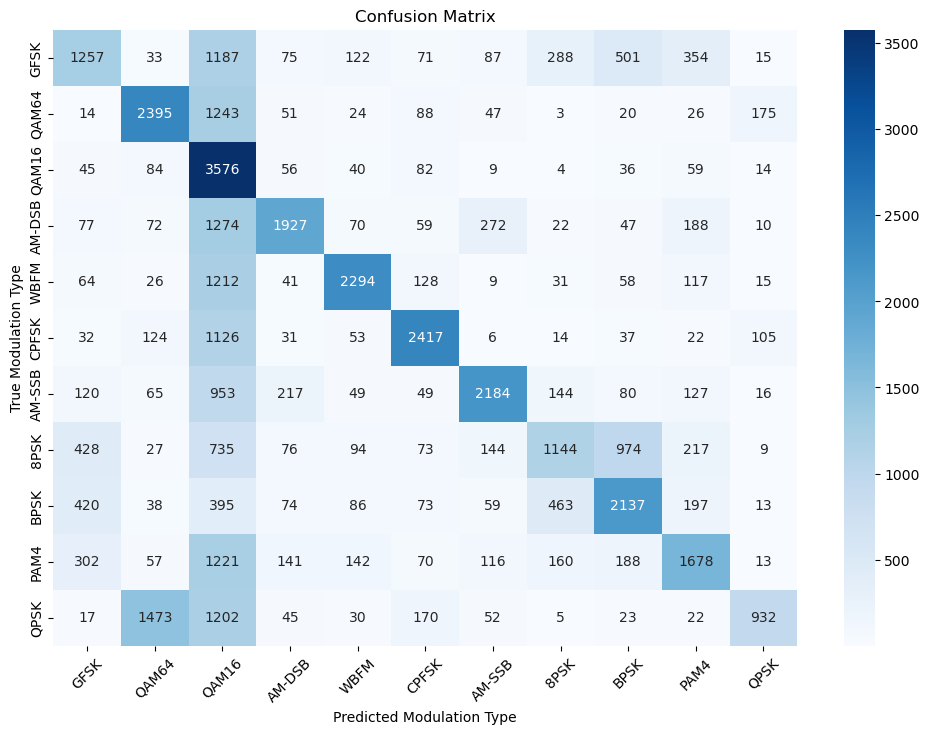

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming your model and data are already defined

# Get predictions
y_pred = model.predict(X_test_reshaped)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()  # Convert predictions to class labels
y_true_classes = tf.argmax(y_test_one_hot, axis=1).numpy()  # Convert true labels to class labels

# Extract modulation types from the dataset keys
modulation_types = list(set(key[0] for key in dataset.keys()))  # Unique modulation types

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modulation_types, yticklabels=modulation_types)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Modulation Type')
plt.ylabel('True Modulation Type')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

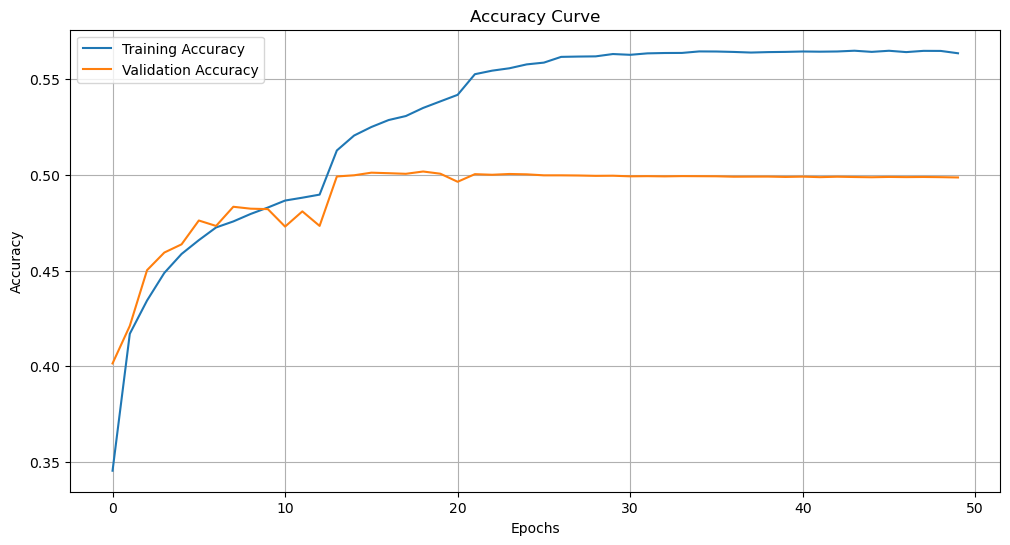

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

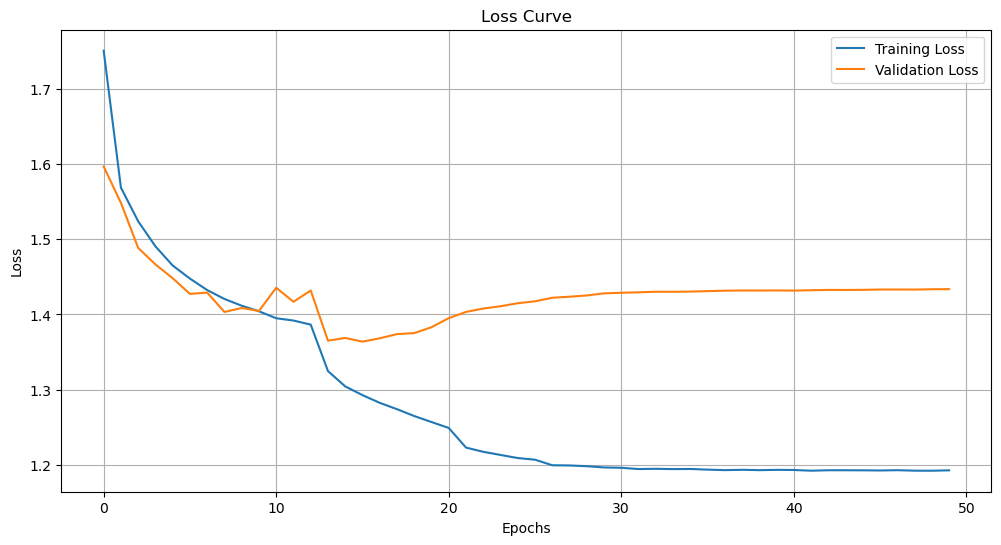

In [24]:
import matplotlib.pyplot as plt

# Assuming `history` is the output from model.fit()
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

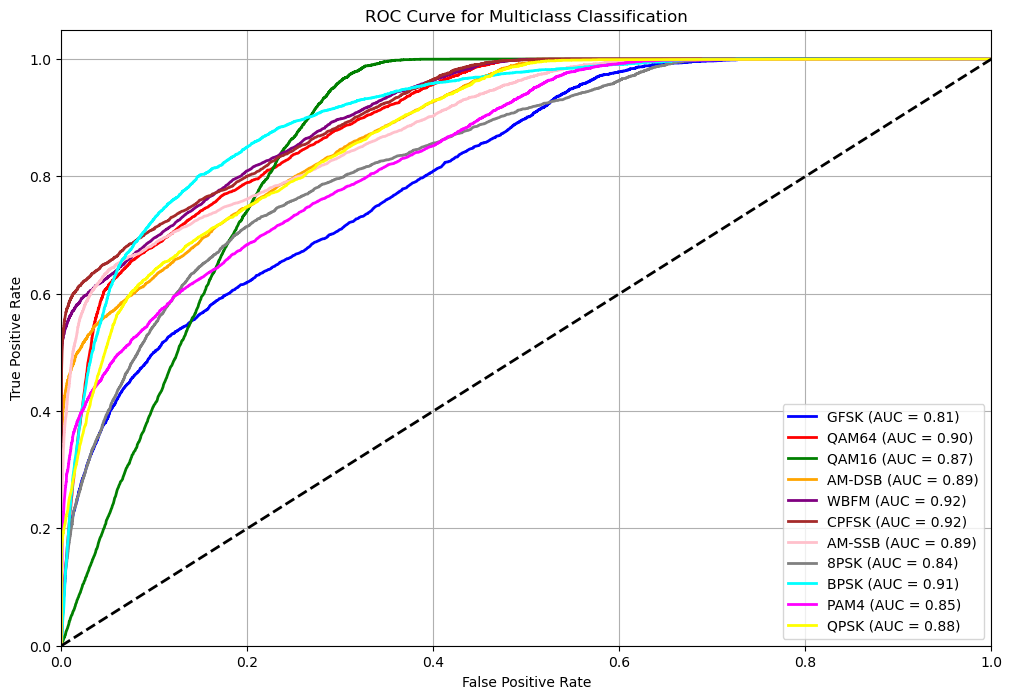

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Extract modulation types from the dataset keys
modulation_types = list(set(key[0] for key in dataset.keys()))  # Unique modulation types

# Assuming `y_true_classes` are your true labels and `y_pred` are the predicted probabilities from the model
n_classes = len(modulation_types)  # Number of classes
y_true_binarized = label_binarize(y_true_classes, classes=[i for i in range(n_classes)])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{modulation_types[i]} (AUC = {roc_auc[i]:.2f})')  # Use modulation type name here

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()